# MONTE CARLO DROPOUT 
 - Replicação do estado da arte 
 
Incerteza Epistêmica em Redes Neurais - Gerson Eduardo de Mello 

Esta é uma replicação de uma publicação de Matheus Facure em Outubro de 22 na página do LAMFO ( LAMFO - Laboratório de Aprendizado de Máquina em Finanças e Organizações) da universidade de Brasília ( UnB ) https://lamfo-unb.github.io/2017/10/22/Monte-Carlo-Dropout/ . Nesta publicação ele apresenta a técnica de Monte Carlo Dropout proposta por  por Yarin Gal . O código do post é esse:  https://github.com/matheusfacure/Tutoriais-de-AM/blob/master/Redes%20Neurais%20Artificiais/Bayesian-NN/BNN-Regression.ipynb

#Descrição do método proposto por Yarin Gal:

Em 2015, Yarin Gal mostrou que é possível obter incerteza a partir de redes neurais quase que gratuitamente, se olhássemos técnicas de regularização estocásticas, como Dropout, sob uma perspectiva Bayesiana. Dropout (Srivastava et al, ‎2014) é uma técnica utilizada na maioria das redes neurais modernas para prevenir sobre-ajustamento. Durante o treinamento, Dropout funciona zerando aleatoriamente uma percentagens de neurônios nas camadas da rede neural. No momento de fazer previsões, todos os neurônios são mantidos e a rede neural atua como uma grande mistura de sub-redes menores. Durante o treinamento do modelo, nada muda; mas, durante o teste mantemos a probabilidade de Dropout fixada durante o treino e realizamos T forward-pass pela rede, coletando assim T previsões y para cada amostra. Assim para cada ponto teremos uma previsão para a média e uma previsão para a variância, que será nossa medida de incerteza.

Obs:
Foram necessáris duas correções que no código original estavam erradas: 

linha 61- label "prevista " e "real" estavam incertidas 

linha 67 substituição do código: 
for shade in range(1, 5): plt.fill_between(t, mu, mu-sigma * (.5*shade), alpha=0.2, color="C2")
pelo código:
for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [44]:
data = pd.read_csv("hour.csv")
data.sort_values(["dteday", "hr"], inplace=True)
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [45]:
#Vamos usar apenas demanda (cnt) passada para tentar prever a demanda na hora seguinte. A seguir, criamos 10 lags dessa variável. Assim, vamos usar as demandas das dez horas passadas para tentar prever a demanda da hora seguinte.

In [46]:
demanda = data[['cnt']]
n_steps = 10

# faz 10 lags da variável cnt
for time_step in range(1, n_steps+1):
    demanda['cnt'+str(time_step)] = demanda[['cnt']].shift(-time_step).values

demanda.dropna(inplace=True) # dropa os lags que resultaram e nulos
demanda.head()

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_10932\1871593754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda['cnt'+str(time_step)] = demanda[['cnt']].shift(-time_step).values
C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_10932\1871593754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda['cnt'+str(time_step)] = demanda[['cnt']].shift(-time_step).values
C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_10932\1871593754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,cnt,cnt1,cnt2,cnt3,cnt4,cnt5,cnt6,cnt7,cnt8,cnt9,cnt10
0,16,40.0,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0
1,40,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0
2,32,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0
3,13,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,94.0
4,1,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,94.0,106.0


In [47]:
#Separamos as demandas que serão usadas como variáveis e aquela que será prevista

In [48]:
X = demanda.iloc[:, :n_steps].values
y = demanda.iloc[:, -1:].values

print(X.shape, y.shape)

(17369, 10) (17369, 1)


In [49]:
#Separamos os dados em treino e teste, mantendo as últimas 500 horas para teste.

In [50]:
n_test = 500

X_train, X_test = X[:-n_test, :], X[-n_test:, :]
y_train, y_test = y[:-n_test, :], y[-n_test:, :]

In [51]:
#Embaralhamos os dados de treino para treinar com Gradiente Descendente Estocástico

In [52]:
shuffle_mask = np.arange(0, X_train.shape[0])
np.random.shuffle(shuffle_mask)

X_train = X_train[shuffle_mask]
y_train = y_train[shuffle_mask]

In [53]:

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [54]:
#construimos a rede neural

In [55]:
n_input = X.shape[-1]
num_out = 1

p_dropout = 0.5
lbd = 1e-4

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3)

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 100)               1100      
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,301
Trainable params: 11,301
Non-trai

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [56]:
#treinamos nossa rede por 15000 interações 

In [72]:
epochs = 3000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 5,
            epochs=epochs,
            verbose=0)

In [58]:
#Avaliamos a performance do modelo

In [59]:
from sklearn import metrics

y_hat_train = model.predict(X_train)
metrics.r2_score(y_train, y_hat_train)

528/528 [==============================] - 0s 541us/step


0.8383254497342942

In [60]:
y_hat_test = model.predict(X_test)
metrics.r2_score(y_test, y_hat_test)

16/16 [==============================] - 0s 1ms/step


0.845053404261592

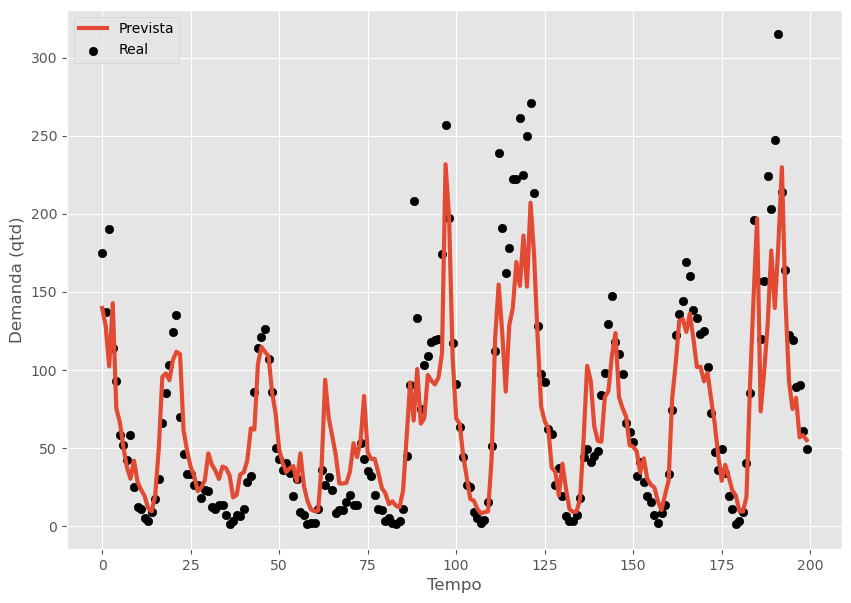

In [61]:
n = 200

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test[-200:], label="Prevista", lw=3)
plt.scatter(range(n), y_test[-200:], color="black", label="Real")
plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

Incerteza
Realizamos 1000 forwad-passes pela rede neural e obtemos 1000 previsões para cada ponto.

In [62]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_test.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [63]:
y_hat_mc.shape

(500, 1000)

In [64]:
#Computamos média e variância para cada ponto no set de teste.

In [65]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1)
y_hat_test_variance = np.var(y_hat_mc, axis=1)
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1

In [66]:
metrics.r2_score(y_test, y_hat_test_mean)

0.9047504542217021

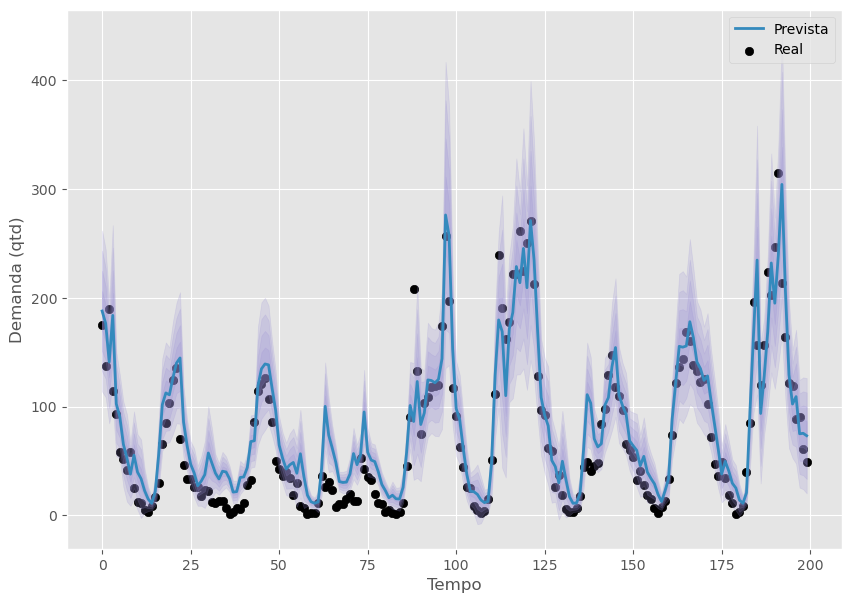

In [67]:
n = 200
t = range(n) 
mu = y_hat_test_mean[-200:]
sigma = np.sqrt(y_hat_test_variance[-200:])

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista", color="C1", lw=2)
plt.scatter(t, y_test[-200:], color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

In [68]:
X_train, y_train = X[:-n_test, :], y[:-n_test, :]

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_train]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_train.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [69]:
l = 10
y_hat_train_mean = np.mean(y_hat_mc, axis=1)
y_hat_train_variance = np.var(y_hat_mc, axis=1)
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_train_variance += tau**-1

In [70]:
metrics.r2_score(y_train, y_hat_train_mean)

0.9367757978055598

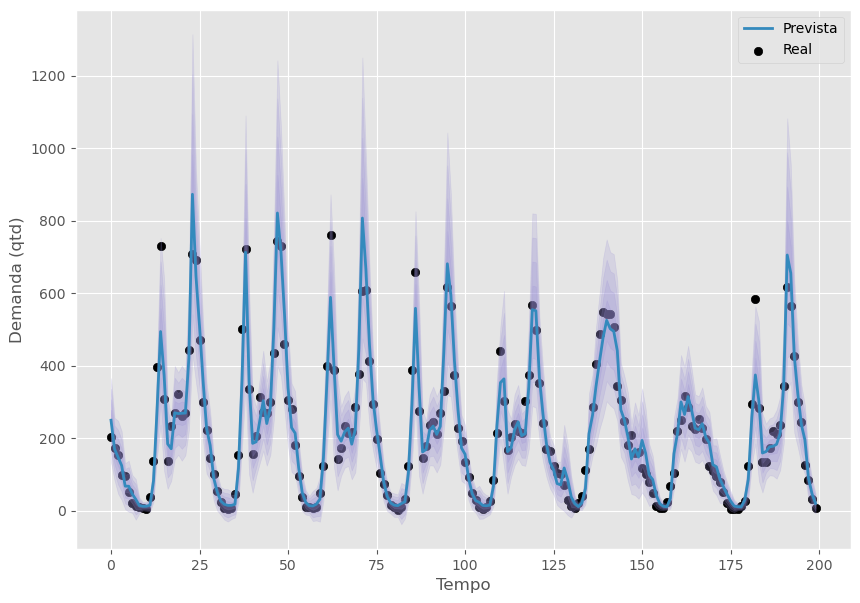

In [71]:
n = 200
t = range(n) 
mu = y_hat_train_mean[-200:]
sigma = np.sqrt(y_hat_train_variance[-200:])

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista", color="C1", lw=2)
plt.scatter(t, y_train[-200:], color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2") # 90% IC

plt.ylabel("Demanda (qtd)")
plt.xlabel("Tempo")
plt.legend(loc="best")
f.savefig("rnn_demanda_train.png")
plt.show()